# Tracking Gradients with PyTorch Hooks
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tracking-Gradients-with-PyTorch-Hooks" data-toc-modified-id="Tracking-Gradients-with-PyTorch-Hooks-1">Tracking Gradients with PyTorch Hooks</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1">Import Libraries</a></span></li><li><span><a href="#Initialize-Model" data-toc-modified-id="Initialize-Model-1.2">Initialize Model</a></span></li></ul></li><li><span><a href="#Manual-Tracking" data-toc-modified-id="Manual-Tracking-2">Manual Tracking</a></span><ul class="toc-item"><li><span><a href="#Mean-of-activations-per-layer" data-toc-modified-id="Mean-of-activations-per-layer-2.1">Mean of activations per layer</a></span></li><li><span><a href="#STD-of-activations-per-layer" data-toc-modified-id="STD-of-activations-per-layer-2.2">STD of activations per layer</a></span></li></ul></li><li><span><a href="#PyTorch-Hooks" data-toc-modified-id="PyTorch-Hooks-3">PyTorch Hooks</a></span><ul class="toc-item"><li><span><a href="#Register-functions-as-Hooks" data-toc-modified-id="Register-functions-as-Hooks-3.1">Register functions as Hooks</a></span></li><li><span><a href="#Mean-of-activations-per-layer" data-toc-modified-id="Mean-of-activations-per-layer-3.2">Mean of activations per layer</a></span></li><li><span><a href="#STD-of-activations-per-layer" data-toc-modified-id="STD-of-activations-per-layer-3.3">STD of activations per layer</a></span></li></ul></li><li><span><a href="#Customizable-Hooks" data-toc-modified-id="Customizable-Hooks-4">Customizable Hooks</a></span><ul class="toc-item"><li><span><a href="#Single-Hook" data-toc-modified-id="Single-Hook-4.1">Single Hook</a></span></li><li><span><a href="#Container-for-hooks" data-toc-modified-id="Container-for-hooks-4.2">Container for hooks</a></span></li><li><span><a href="#Multiple-Hooks" data-toc-modified-id="Multiple-Hooks-4.3">Multiple Hooks</a></span></li></ul></li><li><span><a href="#Histogram-Health-of-Model" data-toc-modified-id="Histogram-Health-of-Model-5">Histogram Health of Model</a></span></li></ul></div>

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from utils import *

import math
import torch.nn as nn
import torch.nn.functional as F

## Initialize Model

In [3]:
bs = 500
n_classes = 10
lr = 0.1

In [4]:
x_train, y_train, x_test, y_test = get_data()
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, batch_size=bs)

In [5]:
data = Databunch(train_dl, test_dl, n_classes)

In [6]:
class DeepNN(nn.Module):
    '''A deep neural network with n layers'''
        
    def __init__(self, x_dim, y_dim, n_layers):
        super().__init__()
        # get an exponentially spaced array of layer dimensions
        def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
        layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
        # construct the list of layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            self.layers.append(nn.Linear(in_dim, out_dim))
            self.layers.append(nn.ReLU())
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

In [7]:
model = DeepNN(x_dim = data.train_ds.x.shape[1],
               y_dim = data.n_classes,
               n_layers = 3)

In [8]:
model

DeepNN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=184, bias=True)
    (1): ReLU()
    (2): Linear(in_features=184, out_features=43, bias=True)
    (3): ReLU()
    (4): Linear(in_features=43, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

In [10]:
learner = Learner(model, data, opt, loss_func)

In [11]:
controller = Controller([StatsReporter([accuracy])])
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 1.019 	 metrics: [0.7213] 	Valid loss: 0.362 	 metrics: [0.8978] 	
EPOCH#1 	Train loss: 0.347 	 metrics: [0.89824] 	Valid loss: 0.272 	 metrics: [0.9186] 	
EPOCH#2 	Train loss: 0.269 	 metrics: [0.92078] 	Valid loss: 0.229 	 metrics: [0.9328] 	


In [12]:
accuracy(learner.model(data.train_ds.x), data.train_ds.y)

tensor(0.9277)

# Manual Tracking

In [13]:
class DeepNN(nn.Module):
    '''A deep neural network with n layers'''
        
    def __init__(self, x_dim, y_dim, n_layers):
        super().__init__()
        layers = self._get_linear_layers(x_dim, y_dim, n_layers)
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]  
        
    def forward(self, x):
        for i,l in enumerate(self.layers):
            x = l.forward(x)
            if self.training:
                self.act_means[i].append(x.mean())
                self.act_stds[i].append(x.std())
        return x
    
    def _get_linear_layers(self, x_dim, y_dim, n_layers):
        def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
        layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
        layers = []
        for i in range(n_layers):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
        return layers

In [14]:
model = DeepNN(784, 10, 5)
model

DeepNN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=328, bias=True)
    (1): ReLU()
    (2): Linear(in_features=328, out_features=137, bias=True)
    (3): ReLU()
    (4): Linear(in_features=137, out_features=58, bias=True)
    (5): ReLU()
    (6): Linear(in_features=58, out_features=24, bias=True)
    (7): ReLU()
    (8): Linear(in_features=24, out_features=10, bias=True)
    (9): ReLU()
  )
)

In [15]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

In [16]:
learner = Learner(model, data, opt, loss_func)

In [17]:
controller = Controller([StatsReporter([accuracy])])
controller.train(learner, epochs=5)

EPOCH#0 	Train loss: 2.293 	 metrics: [0.18742] 	Valid loss: 2.266 	 metrics: [0.2572] 	
EPOCH#1 	Train loss: 1.943 	 metrics: [0.35182] 	Valid loss: 1.238 	 metrics: [0.5867] 	
EPOCH#2 	Train loss: 0.944 	 metrics: [0.68118] 	Valid loss: 0.605 	 metrics: [0.7973] 	
EPOCH#3 	Train loss: 0.593 	 metrics: [0.79836] 	Valid loss: 0.487 	 metrics: [0.828] 	
EPOCH#4 	Train loss: 0.493 	 metrics: [0.8252] 	Valid loss: 0.427 	 metrics: [0.8467] 	


## Mean of activations per layer

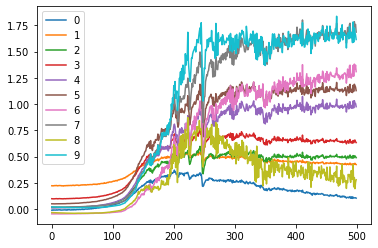

In [19]:
for layer_act_mean in model.act_means:
    plt.plot(layer_act_mean)
plt.legend(range(len(model.layers)));

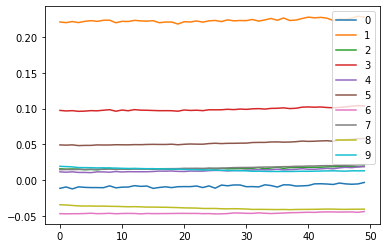

In [20]:
for layer_act_mean in model.act_means:
    plt.plot(layer_act_mean[:50])
plt.legend(range(len(model.layers)));

## STD of activations per layer

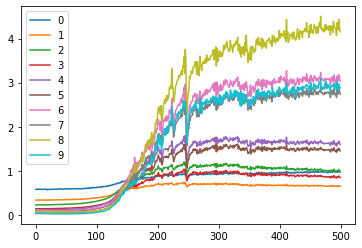

In [21]:
for layer_act_std in model.act_stds:
    plt.plot(layer_act_std)
plt.legend(range(len(model.layers)));

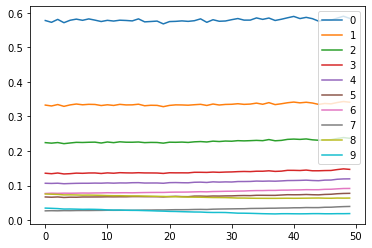

In [22]:
for layer_act_std in model.act_stds:
    plt.plot(layer_act_std[:50])
plt.legend(range(len(model.layers)));

# PyTorch Hooks

In [23]:
def get_linear_layers(x_dim, y_dim, n_layers):
    def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
    layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
    layers = []
    for i in range(n_layers):
        in_dim, out_dim = layer_dims[i], layer_dims[i+1]
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.ReLU())
    return layers

In [24]:
model = nn.Sequential(*get_linear_layers(784, 10, 6))

## Register functions as Hooks

In [25]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

def append_stats(i, module, inp, out):
    if module.training:
        act_means[i].append(out.data.mean())
        act_stds[i].append(out.data.std())

for i,layer in enumerate(model):
    layer.register_forward_hook(partial(append_stats, i))

In [26]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

In [27]:
learner = Learner(model, data, opt, loss_func)

In [28]:
controller = Controller([StatsReporter([accuracy])])
controller.train(learner, epochs=5)

EPOCH#0 	Train loss: 2.291 	 metrics: [0.11758] 	Valid loss: 2.266 	 metrics: [0.1132] 	
EPOCH#1 	Train loss: 1.947 	 metrics: [0.36142] 	Valid loss: 1.545 	 metrics: [0.4923] 	
EPOCH#2 	Train loss: 0.910 	 metrics: [0.68902] 	Valid loss: 0.472 	 metrics: [0.8647] 	
EPOCH#3 	Train loss: 0.416 	 metrics: [0.87694] 	Valid loss: 0.309 	 metrics: [0.9108] 	
EPOCH#4 	Train loss: 0.278 	 metrics: [0.9201] 	Valid loss: 0.209 	 metrics: [0.9404] 	


## Mean of activations per layer

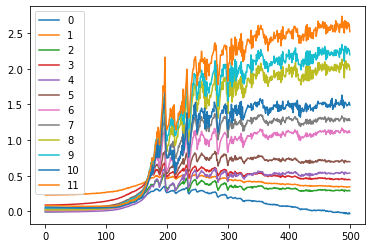

In [30]:
for l in act_means: plt.plot(l)
plt.legend(range(len(model)))

## STD of activations per layer

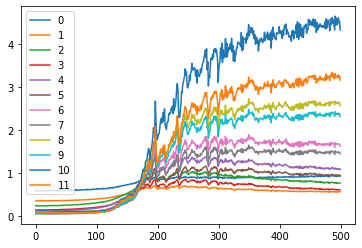

In [31]:
for l in act_stds: plt.plot(l)
plt.legend(range(len(model)))

# Customizable Hooks

## Single Hook

In [32]:
class Hook:
    def __init__(self, module, func):
        self.handle = module.register_forward_hook(partial(func, self))
    
    def remove(self):  self.handle.remove()
    def __del__(self): self.remove()

In [33]:
def layer_stats(hook, module, input, output):
    if not hasattr(hook, 'means') or not hasattr(hook, 'stds'):
        hook.means, hook.stds = [],[] 
    if module.training:
        hook.means.append(output.data.mean())
        hook.stds.append(output.data.std())

In [34]:
model = nn.Sequential(*get_linear_layers(784, 10, 6))

In [35]:
hooks = [Hook(layer, layer_stats) for layer in model]

In [36]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

learner = Learner(model, data, opt, loss_func)

controller = Controller([StatsReporter([accuracy])])
controller.train(learner, epochs=5)

EPOCH#0 	Train loss: 2.298 	 metrics: [0.1435] 	Valid loss: 2.287 	 metrics: [0.332] 	
EPOCH#1 	Train loss: 2.195 	 metrics: [0.32626] 	Valid loss: 1.885 	 metrics: [0.385] 	
EPOCH#2 	Train loss: 1.546 	 metrics: [0.46232] 	Valid loss: 1.134 	 metrics: [0.6041] 	
EPOCH#3 	Train loss: 0.999 	 metrics: [0.65462] 	Valid loss: 0.758 	 metrics: [0.7343] 	
EPOCH#4 	Train loss: 0.682 	 metrics: [0.76296] 	Valid loss: 0.531 	 metrics: [0.8219] 	


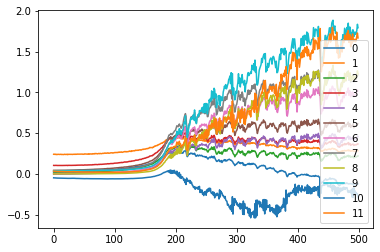

In [37]:
for hook in hooks:
    plt.plot(hook.means)
plt.legend(range(len(model)))

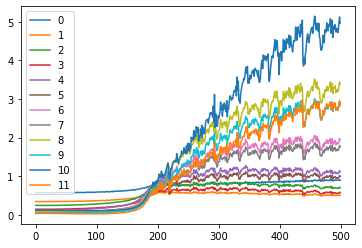

In [38]:
for hook in hooks:
    plt.plot(hook.stds)
plt.legend(range(len(model)))

## Container for hooks

In [39]:
class ListContainer:
    '''A list container of objects with numpy array behaviour'''
    
    def __init__(self, item_list):
        assert isinstance(item_list, list), "Must be a list"
        self.items = item_list
    
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0], bool):
                # boolean mask
                assert len(idx) == len(self)
                return [i for i, mask in zip(self.items, idx) if mask]
            # list indices
            return [self.items[i] for i in idx]
    
    def __repr__(self):
        header = f"{self.__class__.__name__} ({len(self.items)} items)\n"
        if len(self.items) <= 10:
            body = f"{self.items}"
        else:
            body = f"{self.items[:10]}..."
        return header + body
        
    def __len__(self):          return len(self.items)
    def __iter__(self):         return iter(self.items)
    def __setitem(self, i, v):  self.items[i] = v
    def __delitem(self, i):     del(self.items[i])

In [40]:
small = ListContainer([1,2,3])
large = ListContainer(list(range(100)))
mask  = ListContainer([True, False, True])

In [41]:
small

ListContainer (3 items)
[1, 2, 3]

In [42]:
large

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...

In [43]:
small[mask]

[1, 3]

## Multiple Hooks

In [44]:
class Hooks(ListContainer):
    '''List container of hooks'''
    
    def __init__(self, model, func):
        super().__init__([Hook(layer, func) for layer in model])
    
    def __enter__(self, *args): return self
    def __exit__(self, *args):  self.remove()
    def __del__(self):          self.remove()
    
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    
    def remove(self):
        for hook in self: hook.remove()

In [45]:
model = nn.Sequential(*get_linear_layers(784, 10, 3))

EPOCH#0 	Train loss: 1.303 	 metrics: [0.60352] 	Valid loss: 0.811 	 metrics: [0.7297] 	
EPOCH#1 	Train loss: 0.796 	 metrics: [0.7257] 	Valid loss: 0.719 	 metrics: [0.7441] 	
EPOCH#2 	Train loss: 0.728 	 metrics: [0.7393] 	Valid loss: 0.666 	 metrics: [0.7553] 	
EPOCH#3 	Train loss: 0.687 	 metrics: [0.74844] 	Valid loss: 0.641 	 metrics: [0.764] 	
EPOCH#4 	Train loss: 0.658 	 metrics: [0.75442] 	Valid loss: 0.621 	 metrics: [0.7675] 	


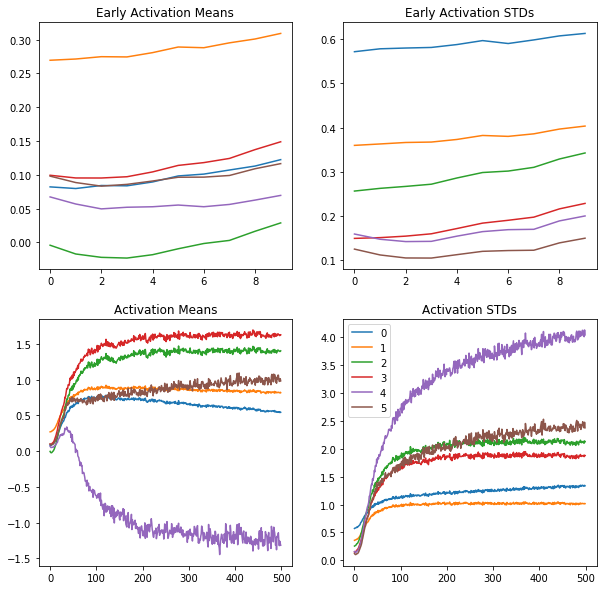

In [46]:
with Hooks(model, layer_stats) as hooks:
    # train
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_func = F.cross_entropy
    learner = Learner(model, data, opt, loss_func)
    controller = Controller([StatsReporter([accuracy])])
    controller.train(learner, epochs=5)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                                 figsize=(10,10))   
    # early health plot
    ax1.title.set_text("Early Activation Means")
    ax2.title.set_text("Early Activation STDs")
    for hook in hooks:
        ax1.plot(hook.means[:10])
        ax2.plot(hook.stds[:10])
    plt.legend(range(len(model)));

    # overall health plot
    ax3.title.set_text("Activation Means")
    ax4.title.set_text("Activation STDs")
    for hook in hooks:
        ax3.plot(hook.means)
        ax4.plot(hook.stds)
    plt.legend(range(len(model)));

# Histogram Health of Model